# Experiments on the DAME and FLAME algorithms

The DAME and FLAME algorithms provide fast, large-scale, and high-quality interpretable matches in causal inference. This document serves to replicate some experiments shown by Liu, et al. in [this paper](https://arxiv.org/abs/1806.06802), but rather than use the authors' experimental code, I use the DAME-FLAME Python package, which is publicy available for download [here](https://pypi.org/project/dame-flame/). 

This code was written by Neha Gupta, with some data generating and visualization code copied from Yameng Liu, Awa Dieng. For questions on this code, or on the DAME-FLAME Python Package, please contact Neha at neha.r.gupta "at" duke "dot" edu. 

Currently, this document replicates Figure 2. 

In [1]:
import numpy as np
import pandas as pd
import dame_flame
import matplotlib.pyplot as plt

## First, we generate the data. 

The outcome is generated with 

$$ y=\sum_{i}\alpha_{i}x_{i}+T\sum_{i}\beta_{i}x_{i}+T\sum_{i,\gamma,\gamma>i}x_{i}x_{\gamma} $$

Each of the terms $y, x_i, \alpha_i, \beta_i$ is of size 1xn where n is the total number of units, 30000 in this case. Also, the i is the number of covariates, which is 18 in this case. 

$T\in\{0,1\}$ is the binary treatment indicator. 

In this document, we choose each unit, $x_{in}$ from a Bernoulli distribution with parameter 0.5. We also let $\beta_i\sim N(1.5, 0.15)$
We consider covariates of decaying importance, letting the $\alpha$ to decrease exponentially as $\alpha_i =64\times(1/2)^i$. We index $\gamma$ starting at the 5th covariate. 

Based on this, the true CATT (Conditional Average Treatment Effect on the Treated) is simply
$$ \sum_{i}\beta_{i}x_{i}+\sum_{i,\gamma,\gamma>i}x_{i}x_{\gamma} $$



In [2]:
def construct_sec_order(arr):
    '''
    An intermediate data generation function used for generating second order information, or the 
    third term in the equation above. 
    Input: 
        np.array (all of the X's being used, in this case the 5th item onwards, for all units)
    Output: 
        np.array (of size covariates*units)
    '''
    
    second_order_feature = []
    num_cov_sec = len(arr[0])
    for a in arr:
        tmp = []
        for i in range(num_cov_sec):
            for j in range(i+1, num_cov_sec):
                tmp.append( a[i] * a[j] )
        second_order_feature.append(tmp)
        
    return np.array(second_order_feature)

def data_generation(num_control, num_treated, num_cov):
    '''
    The main data generating function. Creates df based on parameter specs, and computes true CATT
    Input: 
        num_control (int): The number of control variables
        num_treated (int): The number of treated variables
        num_cov (int): The number of covariates
    Output:
        df (dataframe): The main dataframe. The columns will be numbered, and there will be a column
            called 'outcome', and 'treated'.
        true_catt (list): The ith item in this list corresponds to the ith df element's CATT. 
    '''
    xc = np.random.binomial(1, 0.5, size=(num_control, num_cov)) # data for control group
    xt = np.random.binomial(1, 0.5, size=(num_treated, num_cov)) # data for treated group
        
    dense_bs = [ 64*((1/2)**(i+1)) for i in range(num_cov) ] 
    
    yc = np.dot(xc, np.array(dense_bs)) # y for control group 
    
    treatment_eff_coef = np.random.normal( 1.5, 0.15, size=num_cov) # this is beta
    treatment_effect = np.dot(xt, treatment_eff_coef) # this is beta*x
    
    second = construct_sec_order(xt[:,:5])           
    treatment_eff_sec = np.sum(second, axis=1) # this is the last term, x_i*x_gamma
    
    # note that yc is just the 1st term of the below summation. Thus, the CATT is the 2nd two terms
    yt = np.dot(xt, np.array(dense_bs)) + treatment_effect + treatment_eff_sec
    true_catt = treatment_effect + treatment_eff_sec
    
    df1 = pd.DataFrame(xc, columns = range(num_cov))
    df1['outcome'] = yc
    df1['treated'] = 0
    
    df2 = pd.DataFrame(xt, columns = range(num_cov)) 
    df2['outcome'] = yt
    df2['treated'] = 1
    df = pd.concat([df2,df1])

    return df, true_catt


In [3]:
num_treated = 15000
num_control = 15000
num_cov = 18

df, true_catt = data_generation(num_control, num_treated, num_cov)
holdout, _ = data_generation(num_control, num_treated, num_cov)
df = df.reset_index()
holdout = holdout.reset_index()

df = df.drop(['index'], axis=1)
holdout = holdout.drop(['index'], axis=1)


## We call DAME and FLAME on the datasets

### First, for the stopping criteria of 0.3

This means that the algorithm will quit matching and return the output when 30% or less of control units remain unmatched. 

In [4]:
result_dame_30 = dame_flame.DAME_FLAME.DAME(input_data=df, holdout_data=holdout, treatment_column_name="treated", outcome_column_name="outcome", early_stop_un_c_frac=0.3)
dame_matches_30 = result_dame_30[0]

Iteration number:  10
Unmatched treated units:  8999 out of a total of  15000 treated units .
Unmatched control units:  9024 out of a total of  15000 control units
Predictive error of covariates chosen this iteration:  1.3126922219293486
Number of matches made in this iteration:  11349
Number of matches made so far:  13009
In this iteration, the covariates dropped are:  frozenset({'12'})
Iteration number:  20
Unmatched treated units:  5038 out of a total of  15000 treated units .
Unmatched control units:  5108 out of a total of  15000 control units
Predictive error of covariates chosen this iteration:  1.6308037837677136
Number of matches made in this iteration:  7397
Number of matches made so far:  20406
In this iteration, the covariates dropped are:  frozenset({'12', '16'})
We stopped the algorithm when  0.28773333333333334 of the control units remained unmatched


In [5]:
result_flame_30 = dame_flame.DAME_FLAME.FLAME(input_data=df, holdout_data=holdout, treatment_column_name="treated", outcome_column_name="outcome", early_stop_un_c_frac=0.3)
flame_matches_30 = result_flame_30[0]

We stopped the algorithm when  0.15966666666666668 of the control units remained unmatched


### Now, for the stopping criteria of 0.5

This means that the algorithm will quit matching and return the output when 30% or less of control units remain unmatched. 

In [6]:
result_dame_50 = dame_flame.DAME_FLAME.DAME(input_data=df, holdout_data=holdout, treatment_column_name="treated", outcome_column_name="outcome", early_stop_un_c_frac=0.5)
dame_matches_50 = result_dame_50[0]

Iteration number:  10
Unmatched treated units:  8999 out of a total of  15000 treated units .
Unmatched control units:  9024 out of a total of  15000 control units
Predictive error of covariates chosen this iteration:  1.3126922219293486
Number of matches made in this iteration:  11349
Number of matches made so far:  13009
In this iteration, the covariates dropped are:  frozenset({'12'})
We stopped the algorithm when  0.478 of the control units remained unmatched


In [7]:
result_flame_50 = dame_flame.DAME_FLAME.FLAME(input_data=df, holdout_data=holdout, treatment_column_name="treated", outcome_column_name="outcome", early_stop_un_c_frac=0.5)
flame_matches_50 = result_flame_50[0]

We stopped the algorithm when  0.3988 of the control units remained unmatched


## Creating a graph to examine the match results in terms of number of covariates matched on

We'll see that the matches resulting from DAME are based on more covariates than the matches resulting from FLAME. 

In [8]:
# now, we try to determine how many units were matched on each number of covariates

list_covariate_vals = range(0,num_cov+1)

# replace all the '*'s with NAs so we can get a count of the NAs. 
flame_matches_30 = flame_matches_30.replace(to_replace='*', value=np.nan)
dame_matches_30 = dame_matches_30.replace(to_replace='*', value=np.nan)
flame_matches_50 = flame_matches_50.replace(to_replace='*', value=np.nan)
dame_matches_50 = dame_matches_50.replace(to_replace='*', value=np.nan)

# This will map: {number of covariates matched on : number of units matched on that number of covariates}
dict_matched_result_dame_30 = {k:0 for k in list_covariate_vals}
dict_matched_result_flame_30 = {k:0 for k in list_covariate_vals}
dict_matched_result_dame_50 = {k:0 for k in list_covariate_vals}
dict_matched_result_flame_50 = {k:0 for k in list_covariate_vals}

# iterate through the rows in the df and count the number of non-NaN values in the row to determine
# how many units that row was matched on. 
for i in flame_matches_30.count(axis=1):
    dict_matched_result_flame_30[i] += 1
    
for i in dame_matches_30.count(axis=1):
    dict_matched_result_dame_30[i] += 1
    
for i in flame_matches_50.count(axis=1):
    dict_matched_result_flame_50[i] += 1
    
for i in dame_matches_50.count(axis=1):
    dict_matched_result_dame_50[i] += 1

In [20]:
# This determines what will appear in the graph's x axis in the end, since we don't want
# a bunch of rows with zero height

min_key = 18
for key,val in dict_matched_result_flame_30.items():
    if val == 0 and (val+1) != 0:
        min_key = key
# So min_key is the lowest number of covariates that were matched on
x_30 = []
for i in range(num_cov, min_key, -1):
    x_30.append(i)

In [21]:
# And we take the dictionary y data and make it into a list of the right size for the graph
dame_y_vals_30 = []
flame_y_vals_30 = []
dame_y_vals_50 = []
flame_y_vals_50 = []

for num_units in x_30:
    dame_y_vals_30.append(dict_matched_result_dame_30[num_units])
    flame_y_vals_30.append(dict_matched_result_flame_30[num_units])
    
for num_units in x_30:
    dame_y_vals_50.append(dict_matched_result_dame_50[num_units])
    flame_y_vals_50.append(dict_matched_result_flame_50[num_units])

In [22]:
def autolabel(ax, x, y):
    """
    Attach a text label above each bar displaying its height.
    """
    for i in range(len(x)):
        height = y[i]
        xl = x[i]
        ax.text(xl, height,
                '%d' % int(height),
                ha='center', va='bottom', rotation=90, fontsize=ticksize)


def draw_hist(ax, x, x1, x2, dame, flame, percent):
    '''
    Draws a graph of the number of units matched on each number of covariates
    input:
        ax: graph object
        x: array of ints, x-axis values
        x1: array of floats, x-axis left space between bars
        x2: array of floats, x-axis right space between bars
        dame: array of ints, dame bar height
        flame: array of ints, flame bar height
        percent: integer, the stopping criteria used in the match function
    '''

    colors = ['blue', 'red', 'green', 'orange', 'purple', 'yellow']

    ax.bar(x1,  dame, width = 0.4, color="green", label = "DAME, stopping at {}% control units matched".format(percent), hatch="/")
    ax.bar(x2, flame, width = 0.4, color = "orange", label = "FLAME, stopping at {}% control units matched".format(percent), hatch = "\\")
    ax.legend(fontsize=labelsize)
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_xlabel("number of covariates matched on", fontsize=labelsize)
    ax.set_ylabel("number of units matched", fontsize=labelsize)
    ax.set_xticks(x)
    ax.set_ylim(0,max(dame)*1.3)
    ax.tick_params(labelsize=ticksize)
    autolabel(ax, x1, dame)
    autolabel(ax, x2, flame)


Text(0.5, 1.0, 'DAME matches units into groups of larger covariate sizes than FLAME')

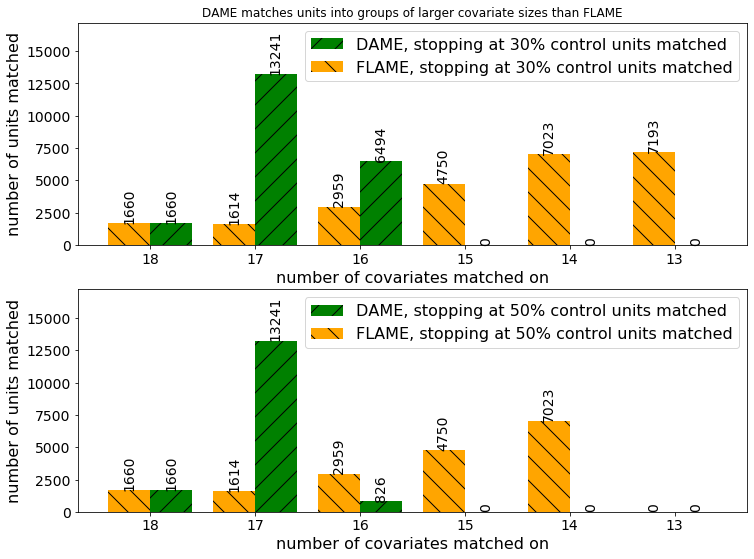

In [23]:
# make the graph

x1 = [e - 0.2 for e in x_30]
x2 = [e + 0.2 for e in x_30]

f, axes = plt.subplots(2, 1, gridspec_kw = {'width_ratios':[1]}, figsize=(12,9))
#f = plt.figure(figsize=(12,9))
#ax = plt.axes()
    
ticksize = 14
labelsize=16
draw_hist(axes[0], x_30, x1, x2, dame_y_vals_30, flame_y_vals_30, 30)
draw_hist(axes[1], x_30, x1, x2, dame_y_vals_50, flame_y_vals_50, 50)

axes[0].set_title("DAME matches units into groups of larger covariate sizes than FLAME")

This shows that DAME produces more high quality matches before resorting to low quality matches. 

## Creating a graph to examine match quality in terms of CATTs

In [25]:
%%capture
# Recall we have the true CATT from above in the data generating process.  
# We need to calculate the estimated CATT of each unit, based on who they were matched with. 
estimated_catt_dame_30 = []
for unit in range(len(result_dame_30[0])):
    if df.loc[unit]['treated'] == 1:
        estimated_catt_dame_30.append(dame_flame.DAME_FLAME.te_of_unit(result_dame_30[0], unit, df, 'treated', 'outcome'))
        

estimated_catt_dame_50 = []
for unit in range(len(result_dame_50[0])):
    if df.loc[unit]['treated'] == 1:
        estimated_catt_dame_50.append(dame_flame.DAME_FLAME.te_of_unit(result_dame_50[0], unit, df, 'treated', 'outcome'))
        

In [26]:
# getting the dame results graph-ready

xs_dame_30 = []
ys_dame_30 = []
sum_squares = 0
num_values = 0
for i in range(len(estimated_catt_dame_30)):
    if estimated_catt_dame_30[i] != False:
        xs_dame_30.append(true_catt[i])
        ys_dame_30.append(estimated_catt_dame_30[i])
        num_values += 1
        sum_squares += (true_catt[i] - estimated_catt_dame_30[i])**2
mse_dame_30 = sum_squares/num_values

xs_dame_50 = []
ys_dame_50 = []
sum_squares = 0
num_values = 0
for i in range(len(estimated_catt_dame_50)):
    if estimated_catt_dame_50[i] != False:
        xs_dame_50.append(true_catt[i])
        ys_dame_50.append(estimated_catt_dame_50[i])
        num_values += 1
        sum_squares += (true_catt[i] - estimated_catt_dame_50[i])**2
mse_dame_50 = sum_squares/num_values

In [27]:
%%capture
# We do the above for flame as well
# We need to calculate the estimated CATT of each unit, based on who they were matched with. 
estimated_catt_flame_30 = []
for unit in range(len(result_flame_30[0])):
    if df.loc[unit]['treated'] == 1:
        estimated_catt_flame_30.append(dame_flame.DAME_FLAME.te_of_unit(result_flame_30[0], unit, df, 'treated', 'outcome'))

estimated_catt_flame_50 = []
for unit in range(len(result_flame_50[0])):
    if df.loc[unit]['treated'] == 1:
        estimated_catt_flame_50.append(dame_flame.DAME_FLAME.te_of_unit(result_flame_50[0], unit, df, 'treated', 'outcome'))
        

In [28]:
# getting the flame results graph-ready

xs_flame_30 = []
ys_flame_30 = []
sum_squares = 0
num_values = 0
for i in range(len(estimated_catt_flame_30)):
    if estimated_catt_flame_30[i] != False:
        xs_flame_30.append(true_catt[i])
        ys_flame_30.append(estimated_catt_flame_30[i])
        num_values += 1
        sum_squares += (true_catt[i] - estimated_catt_flame_30[i])**2
mse_flame_30 = sum_squares/num_values

xs_flame_50 = []
ys_flame_50 = []
sum_squares = 0
num_values = 0
for i in range(len(estimated_catt_flame_50)):
    if estimated_catt_flame_50[i] != False:
        xs_flame_50.append(true_catt[i])
        ys_flame_50.append(estimated_catt_flame_50[i])
        num_values += 1
        sum_squares += (true_catt[i] - estimated_catt_flame_50[i])**2
mse_flame_50 = sum_squares/num_values

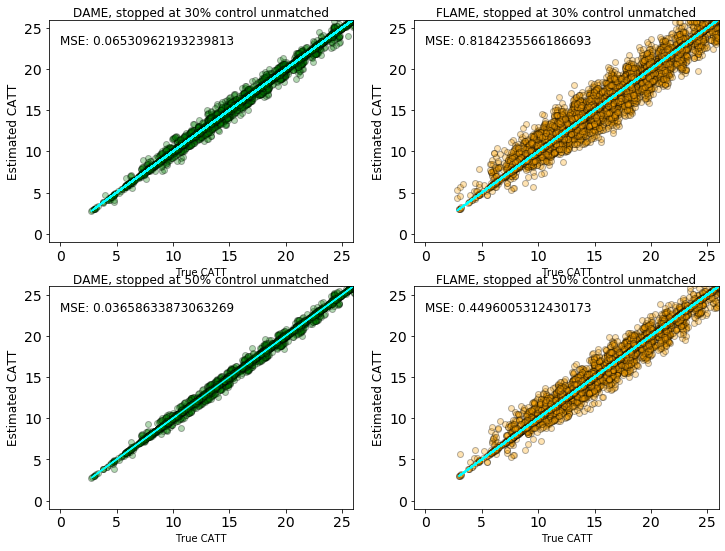

In [33]:
f, axes = plt.subplots(2, 2, gridspec_kw = {'width_ratios':[1, 1]}, figsize=(12,9))

def draw_scatter(ax, x, y, title, color, mse, yticks= False):
    ax.scatter(x, y, c = color, alpha = 0.3, marker = 'o', edgecolor = 'black') # plotting t, a separately 
    ax.plot(x,x, c = 'cyan') # plotting t, a separately 
    ax.set_xticks(range(0, 26, 5))
    ax.set_title(title, pad = 0.2, wrap = True, fontsize=labelsize*.75)
    ax.set_xlim(-1, 26)
    ax.set_ylim(-1, 26)
    ax.tick_params(labelsize=ticksize)
    #ax.spines["top"].set_visible(False)
    if(yticks):
    #    ax.spines["right"].set_visible(False)
        ax.set_yticks(range(0, 26, 5))
        ax.set_ylabel("Estimated CATT", fontsize = labelsize*.75)
    else:
        ax.get_yaxis().set_visible(False)
    #    ax.spines["left"].set_visible(False)
    ax.text(0, 23, "MSE: {}".format(mse), fontsize=labelsize*.75)
    ax.set_xlabel('True CATT')


draw_scatter(axes[0][0], xs_dame_30, ys_dame_30, "DAME, stopped at 30% control unmatched",  "green", mse_dame_30, True)
draw_scatter(axes[0][1], xs_flame_30, ys_flame_30, "FLAME, stopped at 30% control unmatched",  "orange", mse_flame_30, True)
draw_scatter(axes[1][0], xs_dame_50, ys_dame_50, "DAME, stopped at 50% control unmatched",  "green", mse_dame_50, True)
draw_scatter(axes[1][1], xs_flame_50, ys_flame_50, "FLAME, stopped at 50% control unmatched",  "orange", mse_flame_50, True)

So, general, DAME has higher quality matches than FLAME